<a href="https://colab.research.google.com/github/FunmiSomoye-schl/fake_news/blob/main/model_experimentation_fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations and Importations

## Installations

In [1]:
!pip install lingua-language-detector
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.7 MB/s eta 0:00:00


## Importations

### Libraries

In [2]:
import re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from lingua import Language, LanguageDetectorBuilder
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.tag import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#models to evaluate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, PrecisionRecallDisplay, precision_recall_curve, \
    roc_curve, roc_auc_score, average_precision_score, recall_score, precision_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Main Data

In [12]:
main_df = pd.read_excel('scored_posts.xlsx')
data = main_df[['title', 'trustworthiness']]

### Classes and Functions

#### Data Pre-Processing

In [52]:
def lemmatize_pos_tagged_text(text: str, lemmatizer, pos_tag_dict: dict) -> str:
    """Tag words in a sentence with their part of speech,
    then lemmatize using the tags as a reference
    """

    new_sentence_words = []
    tokens = word_tokenize(text)
    pos_tuples = pos_tag(tokens)

    for word_idx, word in enumerate(tokens):
        nltk_word_pos = pos_tuples[word_idx][1]
        wordnet_word_pos = pos_tag_dict.get(nltk_word_pos[0].upper(), None)

        if wordnet_word_pos is not None:
            new_word = lemmatizer.lemmatize(word, wordnet_word_pos)
        else:
            new_word = lemmatizer.lemmatize(word)
        new_sentence_words.append(new_word)

    new_sentence = ' '.join(new_sentence_words)

    return new_sentence


def language_filter(text: str, lang_detector) -> str:
    """
    Replace non-English texts with Nan
    """

    thresh = round(lang_detector.\
                   compute_language_confidence(text, Language.ENGLISH), 3)

    if thresh <= 0.095:
        text = np.NaN
    else:
        text = text

    return text



class NltkPreprocessingSteps:
    def __init__(self, X):
        self.X = X

        #stopwords
        junk_words = ['update'] #commmon reddit word for updated posts
        self.stop_words = stopwords.words('english')
        self.stop_words.extend(junk_words)
        self.stop_words.remove('not')

        #Parts of Speech
        self.pos_tag_dict = {"J": wordnet.ADJ,
                        "N": wordnet.NOUN,
                        "V": wordnet.VERB,
                        "R": wordnet.ADV}


    def to_lower(self):
        self.X = self.X.apply(lambda x: x if pd.isnull(x) else x.lower())

        return self


    def remove_domain_ext(self):
        self.X = self.X.apply(lambda x: ''.\
                              join(w for w in str(x).split('.')[0]))

        return self


    def expand_contractions(self):
        self.X = self.X.apply(
                lambda x: x if pd.isnull(x) else ' '.\
                join([contractions.fix(expanded_word)
                for expanded_word in x.split()]))

        return self


    def remove_mentions(self):
        self.X = self.X.apply(lambda x: x if pd.isnull(x) else
                              re.sub("@[^\s]+", " ", str(x)))

        return self


    def remove_urls(self):
        self.X = self.X.apply(lambda x: x if pd.isnull(x) else
                              re.sub("http[^\s]+", " ", str(x)))

        return self


    def replace_dots(self):
        #Replace periods with white spaces
        self.X = self.X.apply(lambda x: x if pd.isnull(x) else
                              re.sub("[.]", " ", str(x)))

        return self


    def remove_non_alpha(self):
        #Remove all special characters
        self.X = self.X.apply(lambda x: x if pd.isnull(x) else
                              re.sub(r"[^A-Za-z ]+", " ", str(x)))

        return self


    def remove_short_words(self):
        self.X = self.X.apply(lambda x: x if pd.isnull(x) else ' '.\
                              join([word for word in str(x).split()
                              if len(word) > 1]))

        return self


    def remove_stopwords(self):
        self.X = self.X.apply(
                lambda x: x if pd.isnull(x) else ' '.\
                join([word for word in x.split()
                if word not in self.stop_words]))

        return self


    def pos_lemmatize(self):
        lemmatizer = WordNetLemmatizer()
        self.X = self.X.apply(lambda x: x if pd.isnull(x) else
                              lemmatize_pos_tagged_text(x, lemmatizer,
                                                        self.pos_tag_dict))

        return self


    def non_eng_filter(self):
        lang_detector = LanguageDetectorBuilder.from_all_spoken_languages().\
                        build()
        self.X = self.X.apply(lambda x: x if pd.isnull(x) else
                              language_filter(x, lang_detector))

        return self


    def get_processed_text(self):

        return self.X

In [7]:
class TitlePreprocessor(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        pass

    def fit(self, X):
        return self

    def transform(self, X):
        txt_preproc = NltkPreprocessingSteps(X.copy())
        processed_text = \
            txt_preproc\
            .remove_non_alpha()\
            .non_eng_filter()\
            .to_lower()\
            .expand_contractions()\
            .remove_mentions()\
            .remove_urls()\
            .replace_dots()\
            .remove_short_words()\
            .remove_stopwords()\
            .pos_lemmatize()\
            .get_processed_text()

        return processed_text

#### ML

In [ ]:
def get_precision_recall_df(trained_classifier, cap_x_df: pd.Series | pd.DataFrame,
                            y_df: pd.Series | pd.DataFrame,
                            prc_pos_label: int | float | bool | str = None,
                            sample_weight: list[int] = None) -> \
                            tuple[pd.DataFrame, float, float, list[float]]:
    """Get outputs from Sklearn precision_recall_curve"""

    precision, recall, thresholds = precision_recall_curve(
        y_df,
        trained_classifier.predict_proba(cap_x_df)[:, 1],
        pos_label=prc_pos_label,
        sample_weight=sample_weight
    )

    precision_recall_df = pd.DataFrame(
        {
            'precision': precision,
            'recall': recall,
            'thresholds': np.concatenate([thresholds, np.array([np.nan])])
        }
    )

    return precision_recall_df, precision, recall, thresholds


def get_precision_and_recall_for_threshold(precision_recall_df: pd.DataFrame,
                                           threshold: list[float]) \
                                           -> tuple[float, float]:
    """Compute precision and recall for classification threshold"""

    closest_index = (precision_recall_df.thresholds - threshold).abs().idxmin()
    thresh_precision = precision_recall_df.loc[closest_index, 'precision']
    thresh_recall = precision_recall_df.loc[closest_index, 'recall']

    return thresh_precision, thresh_recall


def get_average_precision_score(trained_classifier,
                                cap_x_df: pd.Series | pd.DataFrame,
                                y_df: pd.Series | pd.DataFrame,
                                average: str = 'macro',
                                pos_label: int | float | bool | str = 1,
                                sample_weight: list = None) -> float:
    """Get sklearn average precision score"""

    ave_precision_score = average_precision_score(
        y_true=y_df,
        #retain probabilities for positive outcome only
        y_score=trained_classifier.predict_proba(cap_x_df)[:, 1],
        average=average,
        pos_label=pos_label,
        sample_weight=sample_weight
    )

    return ave_precision_score


def get_binary_precision_recall_curves(trained_classifier,
                                       cap_x_df: pd.Series | pd.DataFrame,
                                       y_df: pd.Series | pd.DataFrame,
                                       prc_pos_label: int | float | bool | str = None,
                                       sample_weight: list = None,
                                       average_precision: float = None,
                                       estimator_name: str = None,
                                       prd_pos_label: int | float | bool | str = None,
                                       classification_threshold: float = 0.5,
                                       print_prc: bool = True,
                                       print_prd: bool = True) \
                                       -> tuple[pd.DataFrame, float, float]:
    """
    Plot two curves: Precision recall curve, and Precision and Recall
    as a function of classification threshold, and return scores
    """

    precision_recall_df, precision, recall, thresholds = \
        get_precision_recall_df(trained_classifier, cap_x_df, y_df,
                                prc_pos_label=prc_pos_label,
                                sample_weight=sample_weight)

    class_thresh_precision, class_thresh_recall = \
        get_precision_and_recall_for_threshold(precision_recall_df,
                                               classification_threshold)

    ave_precision_score = get_average_precision_score(trained_classifier,
                                                      cap_x_df, y_df)

    prediction_recall_score = recall_score(y_df, trained_classifier.\
                                           predict(cap_x_df), average='macro')

    if print_prc:
        plt.plot(thresholds, precision[:-1], "b--", label='precision',
                 linewidth=2)
        plt.plot(thresholds, recall[:-1], "g-", label='recall', linewidth=2)
        plt.vlines(classification_threshold, 0, 1.0, "k", "dotted",
                   label=f'{classification_threshold} threshold')
        plt.legend()
        plt.xlabel('classification threshold')
        plt.ylabel('precision and recall')
        plt.title(f'Precision and Recall as a Function of Classification \
        Threshold\n')
        plt.grid()
        plt.show()

    if print_prd:
        print(f'\nprecision-recall curve:\n')
        disp = PrecisionRecallDisplay(precision, recall,
                                      average_precision=average_precision,
                                      estimator_name=estimator_name,
                                      pos_label=prd_pos_label)
        disp.plot()
        plt.plot(class_thresh_recall, class_thresh_precision, "ko",
                 label=f'classification threshold = {classification_threshold}')
        plt.legend()
        plt.grid()
        plt.title(f'precision-recall curve - ave_precision_score = \
        {round(ave_precision_score, 4)}\n')
        plt.show()

    return precision_recall_df, ave_precision_score, prediction_recall_score


def get_precision_recall_curves(trained_classifier,
                                cap_x_df: pd.Series | pd.DataFrame,
                                y_df: pd.Series | pd.DataFrame,
                                prc_pos_label: int | float | bool | str = None,
                                sample_weight: list = None,
                                average_precision: float = None,
                                estimator_name: str = None,
                                prd_pos_label: int | float | bool | str = None,
                                classification_threshold: float = 0.5,
                                print_prc: bool = True, print_prd: bool = True) \
                                -> tuple[pd.DataFrame, float, float]:
    """Plot Precision recall curves and get scores"""

    precision_recall_df, ave_precision_score, prediction_recall_score = \
            get_binary_precision_recall_curves(trained_classifier, cap_x_df,
                                               y_df, prc_pos_label=prc_pos_label,
                                               sample_weight=sample_weight,
                                               average_precision=average_precision,
                                               estimator_name=estimator_name,
                                               prd_pos_label=prd_pos_label,
                                               classification_threshold=classification_threshold,
                                               print_prc=print_prc,
                                               print_prd=print_prd)

    return precision_recall_df, ave_precision_score, prediction_recall_score


def get_class_eval_dict(eval_dict: dict, score: float, score_name: str) -> dict:
    """Arrange scores in a dictionary"""

    if isinstance(score, dict):
        eval_dict['ave_' + score_name] = np.mean(list(score.values()))

        for k, v in score.items():
            score[k] = round(v, 3)

        eval_dict[score_name] = score

    else:
        eval_dict[score_name] = score

    return eval_dict


def eval_trained_estimator_class(trained_estimator,
                                 cap_x_df: pd.Series | pd.DataFrame,
                                 y_df: pd.Series | pd.DataFrame,
                                 model_selection_stage: str, estimator_name: str,
                                 data_set_type: str, class_eval_dict: dict,
                                 print_eval_results: bool = True) -> dict:
    """
    Compute defined sklearn metrics in class_eval_dict, plot precision recall curves,
    and get evaluation scores
    """
    if estimator_name is None:
        estimator_name = ''
    if model_selection_stage is None:
        model_selection_stage = ''
    if data_set_type is None:
        data_set_type = ''

    eval_dict = {}
    for eval_type, eval_type_list in class_eval_dict.items():
        if eval_type_list[0]:
            kwargs = eval_type_list[1]
            if eval_type == 'get_precision_recall_curves':
                _, ave_precision_score, prediction_recall_score = \
                    get_precision_recall_curves(trained_estimator, cap_x_df,
                                                y_df, **kwargs)

                eval_dict = get_class_eval_dict(eval_dict, ave_precision_score,
                                                'ave_precision_score')

                eval_dict = get_class_eval_dict(eval_dict,
                                                prediction_recall_score,
                                                'ave_recall_score')

    if print_eval_results:
        print(f'{model_selection_stage} of the {estimator_name} estimator \
        predicting on the {data_set_type} data set')
        print('Average Precision score:', eval_dict['ave_precision_score'])
        print('Average Recall score:', eval_dict['ave_recall_score'])

    return eval_dict


def eval_trained_estimators_in_trained_estimator_dict_class(trained_estimator_dict,
                                                            cap_x_df: pd.Series | pd.DataFrame,
                                                            y_df: pd.Series | pd.DataFrame,
                                                            data_set_type: str,
                                                            model_selection_stage: str,
                                                            class_eval_dict: str) \
                                                            -> pd.DataFrame:
    """Evaluate Trained estimators using metrics in class_eval_dict"""

    df_row_dict_list = []
    for estimator_name, trained_estimator in trained_estimator_dict.items():
        print('\n', '*' * 50, sep='')

        eval_dict = \
            eval_trained_estimator_class(trained_estimator, cap_x_df, y_df,
                                         model_selection_stage, estimator_name,
                                         data_set_type, class_eval_dict)
        print('')
        eval_dict['estimator'] = estimator_name
        eval_dict['data_set_type'] = data_set_type
        eval_dict['model_selection_stage'] = model_selection_stage
        df_row_dict_list.append(eval_dict)

    compare_df = pd.DataFrame(df_row_dict_list)

    return compare_df


def fit_collection_of_estimators_title_attr(estimator_names: list[str],
                                            estimator_list: list,
                                            cap_x_df: pd.Series | pd.DataFrame,
                                            y_df: pd.Series | pd.DataFrame,
                                            data_set_type: str,
                                            model_selection_stage: str,
                                            class_eval_dict: dict) \
                                            -> tuple[pd.DataFrame, dict]:
    """
    Fit Estimators on training data and evaluate performance
    on metrics as set in class_eval_dict
    """

    trained_estimator_dict = {}
    for estimator_name, estimator in zip(estimator_names, estimator_list):
        print('')
        print(f'fitting {estimator_name}')

        composite_estimator = Pipeline(steps=[('vect', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                               ('estimator', estimator)])

        trained_estimator_dict[estimator_name] = composite_estimator.fit(cap_x_df,
                                                                         y_df.\
                                                                         values.\
                                                                         ravel()
                                                                         )
    compare_df = \
        eval_trained_estimators_in_trained_estimator_dict_class(trained_estimator_dict,
                                                                cap_x_df, y_df,
                                                                data_set_type,
                                                                model_selection_stage,
                                                                class_eval_dict)

    return compare_df, trained_estimator_dict

In [ ]:
def get_cross_val_score_dict(scoring_dict: dict, estimator,
                             cap_x_df: pd.Series | pd.DataFrame,
                             y_df: pd.Series | pd.DataFrame, cv: int = 5,
                             n_jobs: int = -1, print_scores: bool = True) -> dict:
    """Evaluate cross validation fit and get scores"""

    scores_dict = {}

    for scoring_name, scoring in scoring_dict.items():
        scores_dict[scoring_name] = {}
        scores_dict[scoring_name]['scoring'] = scoring
        scores = cross_val_score(
            estimator,
            X=cap_x_df,
            y=y_df,
            scoring=scoring,
            cv=cv,
            n_jobs=n_jobs,
            verbose=0,
            error_score=np.nan
        )

        # scores_dict[scoring_name]['scores'] = scores
        scores_dict[scoring_name]['mean'] = np.mean(scores)
        scores_dict[scoring_name]['stdev'] = np.std(scores, ddof=1)

        if print_scores:
            print(f'\n{scoring_name} cross_val_score:')
            print(f'(note - classification_threshold = 0.5)\n', sep='')
            print(f'scores: {scores}')
            print(f'np.mean(scores): {np.mean(scores)}')
            print(f'np.std(scores, ddof=1): {np.std(scores, ddof=1)}')

    return scores_dict


def cross_val_estimators_title_attr(estimators_names: list[str], estimators_list: list,
                                    cap_x_df:  pd.Series | pd.DataFrame,
                                    y_df:  pd.Series | pd.DataFrame,
                                    cvs_scoring_dict: dict, cvs_cv: int,
                                    cvs_print: bool) -> pd.DataFrame:
    results_list = []
    for estimator_name, estimator in zip(estimators_names, estimators_list):
        print('')
        print(f'fitting {estimator_name}')
        composite_estimator = Pipeline(steps=[('vect', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                               ('estimator', estimator)])
        scores_dict = get_cross_val_score_dict(cvs_scoring_dict,
                                               composite_estimator, cap_x_df,
                                               y_df, cv=cvs_cv, n_jobs=-1,
                                               print_scores=cvs_print)
        scores_dict['estimator'] = estimator_name
        results_list.append(scores_dict)

    results_df = pd.DataFrame(results_list)

    return results_df

# Modelling

#### Set Variables

In [8]:
#data transformation
title_processor = TitlePreprocessor()

#other variables
model_rndm_st = 42
train_test_rndm = 42
train_val_rndm = 24
test_ratio = 0.2
target = 'trustworthiness'
weight = 'balanced'

## Data Preprocessing

In [42]:
def transform_data(data: pd.DataFrame) -> pd.DataFrame:
    """Preprocess the Title Column"""

    data['title'] = title_processor.fit_transform(data['title'])
    data.dropna(subset=['title'], inplace=True)

    return data

In [ ]:
data.dropna(inplace=True)

<ipython-input-15-f1116dacf2bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [ ]:
df = transform_data(data)

<ipython-input-14-6d4872155c88>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['title'] = title_processor.fit_transform(data['title'])
<ipython-input-14-6d4872155c88>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['title'], inplace=True)


In [ ]:
df.to_csv('disinfo_transformed_data.csv')

## Machine Learning

In [58]:
def get_x_y(data: pd.DataFrame, x_col: str, y_col: str) \
            -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split dataframe into two dataframes containing x variables
    and y variable respectively
    """

    cap_x = data[x_col]
    y = data[y_col]

    return cap_x, y


def classification_df_split(df: pd.DataFrame, test_ratio: int, rndm: int,
                            y: str, shuffle: bool = False,
                            stratify: bool = False) \
                            -> tuple[pd.DataFrame, pd.DataFrame]:
    """Split a dataframe into Train and Test dataframes"""

    tr_df, test_df = train_test_split(df, test_size=test_ratio, random_state=rndm,
                                      shuffle=shuffle, stratify=stratify)
    print('train:', tr_df.shape)
    print('test:', test_df.shape)
    print('')

    print('train target balance: ', tr_df[y].value_counts(normalize=True))
    print('')
    print('test target balance: ', test_df[y].value_counts(normalize=True))

    return tr_df, test_df

In [ ]:
df = pd.read_csv('disinfo_transformed_data.csv', index_col=0)
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230350 entries, 0 to 258102
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   title            230350 non-null  object 
 1   trustworthiness  230350 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.3+ MB


In [ ]:
df['trustworthiness'] = np.where(df['trustworthiness'] > 0.3, 1, 0)

In [ ]:
train_df, test_df = classification_df_split(df, test_ratio, train_test_rndm,
                                            target, shuffle=True,
                                            stratify=df[target])

train: (184280, 2)
test: (46070, 2)

train target balance:  trustworthiness
1    0.958585
0    0.041415
Name: proportion, dtype: float64

test target balance:  trustworthiness
1    0.958585
0    0.041415
Name: proportion, dtype: float64


In [ ]:
train_df, val_df = classification_df_split(train_df, test_ratio, train_test_rndm,
                                           target, shuffle=True,
                                           stratify=train_df[target])

train: (147424, 2)
test: (36856, 2)

train target balance:  trustworthiness
1    0.958582
0    0.041418
Name: proportion, dtype: float64

test target balance:  trustworthiness
1    0.958596
0    0.041404
Name: proportion, dtype: float64


In [ ]:
train_df.to_csv('train_data.csv')
test_df.to_csv('test_data.csv')
val_df.to_csv('val_data.csv')

In [ ]:
tr_cap_x, tr_y = get_x_y(train_df, 'title', 'trustworthiness')
val_cap_x, val_y = get_x_y(val_df, 'title', 'trustworthiness')

### Stratified Sample Cross Val Training

In [ ]:
stratified_train = train_df.groupby('trustworthiness').apply(lambda x: x.sample(frac=0.40))
stratified_train.shape

(58969, 2)

In [ ]:
str_cap_x, str_y = get_x_y(stratified_train, 'title', 'trustworthiness')

In [ ]:
estimator_names = [
    'LogisticRegression',
    'SGDClassifier',
    'SVC',
    'MNB'
]

estimator_list = [
    LogisticRegression(random_state=model_rndm_st, n_jobs=-1, class_weight=weight),
    SGDClassifier(random_state=model_rndm_st, n_jobs=-1, class_weight=weight),
    SVC(class_weight=weight, random_state=model_rndm_st),
    MultinomialNB()
    ]

In [ ]:
scoring_dict={'precision': 'precision', 'recall':'recall'}

cv_dict = cross_val_estimators_title_attr(estimators_names=estimator_names,
                                          estimators_list=estimator_list,
                                          cap_x_df=str_cap_x,
                                          y_df=str_y,
                                          cvs_scoring_dict=scoring_dict,
                                          cvs_cv=5,
                                          cvs_print=False)


fitting LogisticRegression

fitting SGDClassifier

fitting SVC


In [ ]:
cv_dict

,precision,recall,estimator
0,"{'scoring': 'precision', 'mean': 0.97949549407...","{'scoring': 'recall', 'mean': 0.90823853319107...",LogisticRegression
1,"{'scoring': 'precision', 'mean': 0.98137367763...","{'scoring': 'recall', 'mean': 0.87669599801524...",SGDClassifier
2,"{'scoring': 'precision', 'mean': 0.96695056165...","{'scoring': 'recall', 'mean': 0.99789480882151...",SVC
3,"{'scoring': 'precision', 'mean': 0.95858841138...","{'scoring': 'recall', 'mean': 1.0, 'stdev': 0.0}",MNB


Since the aim of this project is to maximise the Recall, we would choose the models with best potential to maximise recall score amongst all tested.

SVC has the best balance between Recall and Precision.
The MNB model also performed satisfactorily.

###Evaluate Best Recall Trained Estimators on Validation Set

#### Refit Best Models on Stratified Train Set without Cross Validation

In [ ]:
eval_estimator_names = ['SVC','MNB']

eval_estimator_list = [
    SVC(class_weight=weight, random_state=model_rndm_st, probability=True),
    MultinomialNB()
    ]

print_plots = True
class_eval_dict={
    'scoring': 'average_precision',
    'get_precision_recall_curves': [True,
                                    {'print_prc': print_plots,
                                     'print_prd': print_plots
                                    }]
}


fitting SVC

fitting MNB

**************************************************


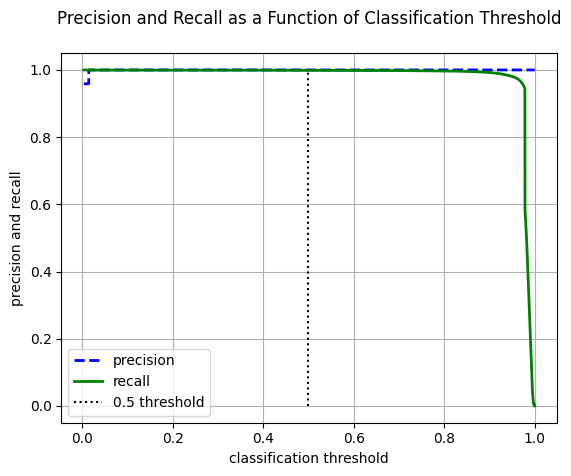


precision-recall curve:



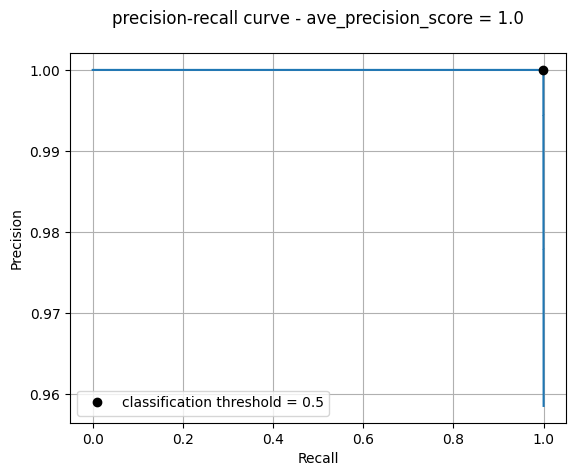

Default of the SVC estimator predicting on the train data set
Average Precision score: 0.9999898562135396
Average Recall score: 0.9995311974808498


**************************************************


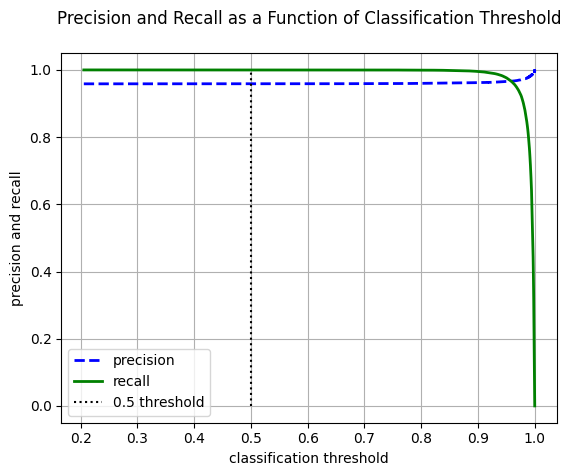


precision-recall curve:



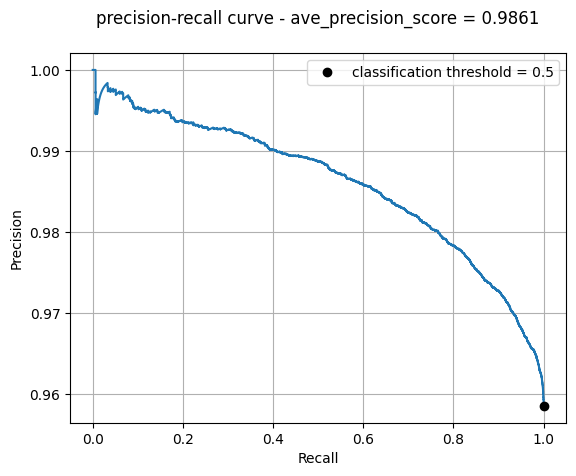

Default of the MNB estimator predicting on the train data set
Average Precision score: 0.9861143307069138
Average Recall score: 0.5004006550789504



,ave_precision_score,ave_recall_score,estimator,data_set_type,model_selection_stage
0,0.999990,0.999531,SVC,train,Default
1,0.986114,0.500401,MNB,train,Default


In [ ]:
default_train_compare_df, trained_default_estimator_dict = \
    fit_collection_of_estimators_title_attr(
        eval_estimator_names,
        eval_estimator_list,
        str_cap_x,
        str_y,
        data_set_type='train',
        model_selection_stage='Default',
        class_eval_dict=class_eval_dict
)
default_train_compare_df

####Eval on Val Set


**************************************************


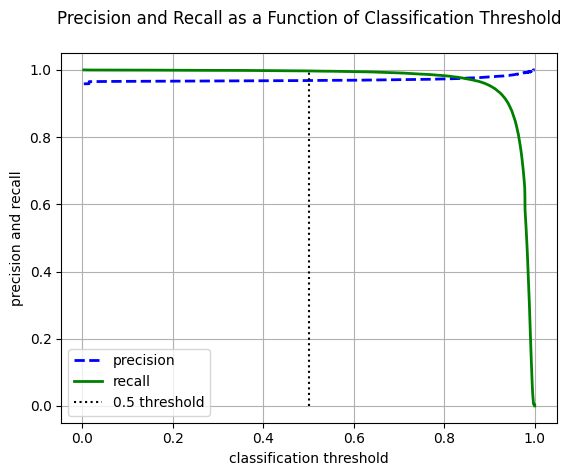


precision-recall curve:



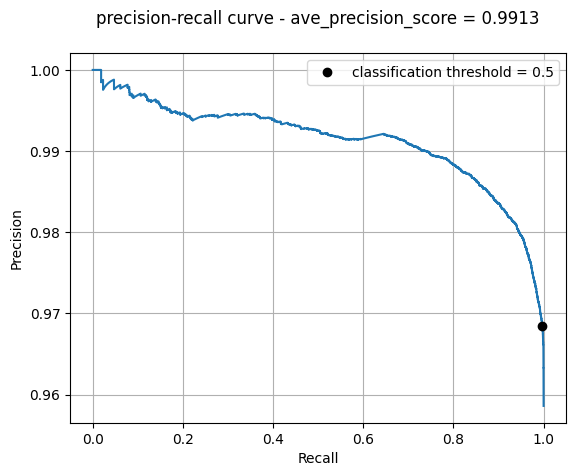

default of the SVC estimator predicting on the validation data set
Average Precision score: 0.9913246014516113
Average Recall score: 0.6174078033771826


**************************************************


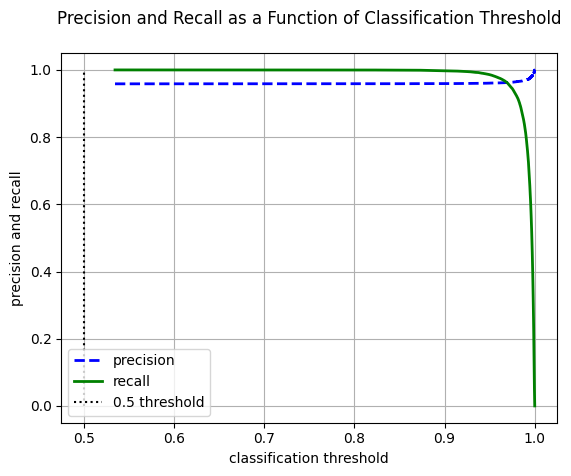


precision-recall curve:



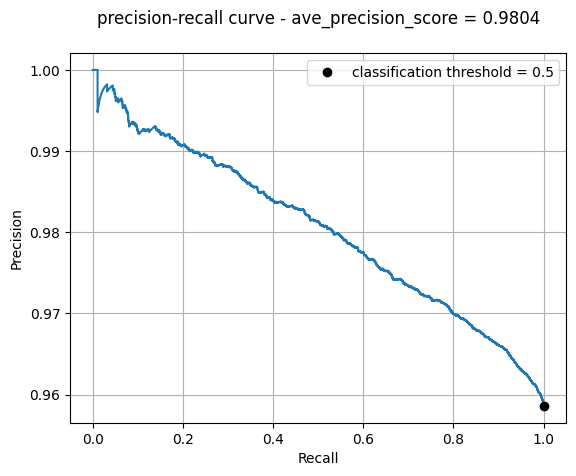

default of the MNB estimator predicting on the validation data set
Average Precision score: 0.9804173175241356
Average Recall score: 0.5



,ave_precision_score,ave_recall_score,estimator,data_set_type,model_selection_stage
0,0.991325,0.617408,SVC,validation,default
1,0.980417,0.500000,MNB,validation,default


In [ ]:
default_validation_compare_df = eval_trained_estimators_in_trained_estimator_dict_class(
    trained_default_estimator_dict,
    val_cap_x,
    val_y,
    data_set_type='validation',
    model_selection_stage='default',
    class_eval_dict=class_eval_dict
)
default_validation_compare_df

The SGDClassifier gives a better balance between precision and recall.

#### Eval on Test Set

In [ ]:
test_df = pd.read_csv('test_data.csv', index_col=0)
ts_cap_x, ts_y = get_x_y(test_df, 'title', 'trustworthiness')

In [ ]:
best_estimator = trained_default_estimator_dict['SVC']

precision_recall_df, ave_precision_score, prediction_recall_score = \
        get_precision_recall_curves(best_estimator, ts_cap_x, ts_y, prc_pos_label=None,
                                    sample_weight=None, average_precision=None,
                                    estimator_name=None, prd_pos_label=None,
                                    print_prc=False, print_prd=False)

print('Average Precision Score', ave_precision_score)
print('Average Prediction Recall Score', prediction_recall_score)

Average Precision Score 0.9918624574377413
Average Prediction Recall Score 0.6310694676936079
